In [1]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
train = pd.read_csv('../data/train/train.csv', low_memory=False)
train.head(3)

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,1.5,69.08,-12,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0


## 새로운 컬럼들 추가
- 1. GHI (= DHI + DNI)
- 2. dewpoint (이슬점)
- 3. sunny (해가 총 떠있는 시간)
- 4. sunrise
- 5. sunset
- 6. date (1~365) ← 얘를 regression하지 말고 바로 zenith나 azi regression
- 7. cloudy (DHI/DNI+0.001)
- 8. temp_diff (일교차)
- 9. zenith (Zenith Angle: 천정각)
- 10. azi (Azimuth: 방위각)

### 1. GHI (= DHI + DNI)

In [46]:
train['GHI'] = train['DHI'] + train['DNI']
train.head(1)

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,GHI
0,0,0,0,0,0,1.5,69.08,-12,0.0,0


### 2. dew (이슬점)

In [47]:
def dewpoint(data):
    rh = data['RH']
    t = data['T']
    gamma = math.log(rh/100) + 17.62*t/(243.12+t)
    dew = (243.12*gamma)/(17.62-gamma)
    return dew

train['dew'] = [dewpoint(train.iloc[i]) for i in range(len(train.index))]

In [48]:
train.head(1)

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,GHI,dew
0,0,0,0,0,0,1.5,69.08,-12,0.0,0,-16.522271


### 3. sunny (해가 총 떠있는 시간)

In [49]:
# Hour & Minute 모두 비교
def time_minute(data):
    hour = data['Hour']
    if data['Minute'] == 0:
        minute = 0
    else: # ==30
        minute = 0.5
    return hour + minute

ghi = train.iloc[np.where(train['DHI'] + train['DNI'] > 0)[0],:].reset_index(drop=True) # GHI (= DHI + DNI)
ghi['time_float'] = [time_minute(ghi.iloc[i]) for i in range(len(ghi.index))]
ghi_min_hour = pd.DataFrame(ghi.groupby(['Day'])['time_float'].min()).reset_index()
ghi_max_hour = pd.DataFrame(ghi.groupby(['Day'])['time_float'].max()).reset_index()
ghi_minus_hour = ghi_max_hour.copy()
ghi_minus_hour['sunny'] = ghi_max_hour['time_float'] - ghi_min_hour['time_float']
ghi_minus_hour.head(3)

,Day,time_float,sunny
0,0,16.5,8.5
1,1,16.5,8.5
2,2,16.5,8.5


In [50]:
train = pd.merge(train, ghi_minus_hour[['Day','sunny']], on='Day')
train.head(1)

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,GHI,dew,sunny
0,0,0,0,0,0,1.5,69.08,-12,0.0,0,-16.522271,8.5


<AxesSubplot:xlabel='Day', ylabel='sunny'>

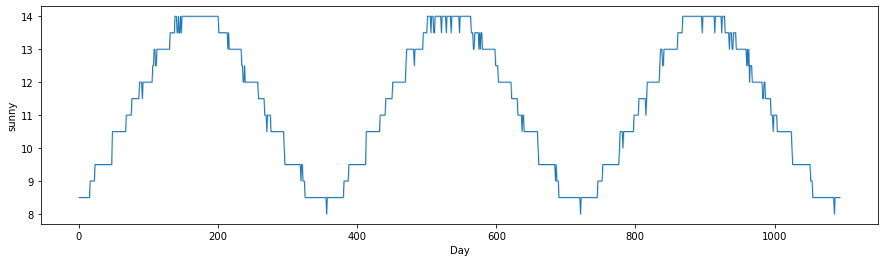

In [51]:
plt.figure(figsize=(15,4))
sns.lineplot(x='Day',y='sunny',data=train, linewidth=1)

### 4. sunrise (일출)

In [52]:
ghi_min_hour = pd.DataFrame(ghi.groupby(['Day'])['time_float'].min()).reset_index()
ghi_min_hour.columns = ['Day', 'sunrise']
train = pd.merge(train, ghi_min_hour, on='Day')
train.head(1)

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,GHI,dew,sunny,sunrise
0,0,0,0,0,0,1.5,69.08,-12,0.0,0,-16.522271,8.5,8.0


### 5. sunset(일몰)

In [53]:
ghi_max_hour = pd.DataFrame(ghi.groupby(['Day'])['time_float'].max()).reset_index()
ghi_max_hour.columns = ['Day', 'sunset']
train = pd.merge(train, ghi_max_hour, on='Day')
train.head(1)

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,GHI,dew,sunny,sunrise,sunset
0,0,0,0,0,0,1.5,69.08,-12,0.0,0,-16.522271,8.5,8.0,16.5


### 6. date (1~365)

In [54]:
# sunny == 8일때를 동지로 잡음 -> 12/22(356일째) cf. 하지 = 6/21
train.iloc[np.where(train['sunny']==train.sunny.min())[0],:]['Day'].unique()

array([ 356,  721, 1086], dtype=int64)

In [56]:
# 1~366(아마 윤달), 1~365, 1~356 : 아마 2017.1.1 ~ 2019.12.31 자료인 듯
# 366+365*2 = 1096
day_ls = [i for i in range(1096)]
date_ls = [i for i in range(0,366)] # 일부러 동지에 356 맞추게
date_ls.extend([i for i in range(1,366)]*2)
day_df = pd.concat([pd.DataFrame(day_ls).rename(columns={0:'Day'}), pd.DataFrame(date_ls).rename(columns={0:'date'})],axis=1)
day_df

,Day,date
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4
...,...,...
1091,1091,361
1092,1092,362
1093,1093,363
1094,1094,364


In [57]:
train = pd.merge(train, day_df, on='Day')
print(train.shape)
train

(52560, 15)


,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,GHI,dew,sunny,sunrise,sunset,date
0,0,0,0,0,0,1.5,69.08,-12,0.0,0,-16.522271,8.5,8.0,16.5,0
1,0,0,30,0,0,1.5,69.06,-12,0.0,0,-16.525742,8.5,8.0,16.5,0
2,0,1,0,0,0,1.6,71.78,-12,0.0,0,-16.061776,8.5,8.0,16.5,0
3,0,1,30,0,0,1.6,71.75,-12,0.0,0,-16.066807,8.5,8.0,16.5,0
4,0,2,0,0,0,1.6,75.20,-12,0.0,0,-15.500215,8.5,8.0,16.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52555,1094,21,30,0,0,2.4,70.70,-4,0.0,0,-8.540093,8.5,8.0,16.5,364
52556,1094,22,0,0,0,2.4,66.79,-4,0.0,0,-9.268639,8.5,8.0,16.5,364
52557,1094,22,30,0,0,2.2,66.78,-4,0.0,0,-9.270551,8.5,8.0,16.5,364
52558,1094,23,0,0,0,2.1,67.72,-4,0.0,0,-9.091976,8.5,8.0,16.5,364


In [59]:
train['date'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

### 7. cloudy (DHI/DNI+0.001)

In [60]:
train['cloudy'] = train['DHI']/(train['DNI']+0.1)
print(train.shape)
train.head(5)

(52560, 16)


,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,GHI,dew,sunny,sunrise,sunset,date,cloudy
0,0,0,0,0,0,1.5,69.08,-12,0.0,0,-16.522271,8.5,8.0,16.5,0,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0,0,-16.525742,8.5,8.0,16.5,0,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0,0,-16.061776,8.5,8.0,16.5,0,0.0
3,0,1,30,0,0,1.6,71.75,-12,0.0,0,-16.066807,8.5,8.0,16.5,0,0.0
4,0,2,0,0,0,1.6,75.20,-12,0.0,0,-15.500215,8.5,8.0,16.5,0,0.0


In [61]:
train[:40]

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,GHI,dew,sunny,sunrise,sunset,date,cloudy
0,0,0,0,0,0,1.5,69.08,-12,0.000000,0,-16.522271,8.5,8.0,16.5,0,0.000000
1,0,0,30,0,0,1.5,69.06,-12,0.000000,0,-16.525742,8.5,8.0,16.5,0,0.000000
2,0,1,0,0,0,1.6,71.78,-12,0.000000,0,-16.061776,8.5,8.0,16.5,0,0.000000
3,0,1,30,0,0,1.6,71.75,-12,0.000000,0,-16.066807,8.5,8.0,16.5,0,0.000000
4,0,2,0,0,0,1.6,75.20,-12,0.000000,0,-15.500215,8.5,8.0,16.5,0,0.000000
5,0,2,30,0,0,1.5,69.29,-11,0.000000,0,-15.524406,8.5,8.0,16.5,0,0.000000
6,0,3,0,0,0,1.5,72.56,-11,0.000000,0,-14.965431,8.5,8.0,16.5,0,0.000000
7,0,3,30,0,0,1.4,72.55,-11,0.000000,0,-14.967106,8.5,8.0,16.5,0,0.000000
8,0,4,0,0,0,1.3,74.62,-11,0.000000,0,-14.624744,8.5,8.0,16.5,0,0.000000
9,0,4,30,0,0,1.3,74.61,-11,0.000000,0,-14.626377,8.5,8.0,16.5,0,0.000000


### 8. temp_diff (일교차)

In [62]:
max_temp = pd.DataFrame(train.groupby(['Day'])['T'].max()).reset_index()
min_temp = pd.DataFrame(train.groupby(['Day'])['T'].min()).reset_index()
diff = min_temp.copy() ; diff=diff.drop(['T'],axis=1,)
diff['temp_diff'] = max_temp['T'] - min_temp['T']
diff.head(1)

,Day,temp_diff
0,0,9


In [63]:
train = pd.merge(train,diff,on='Day')
print(train.shape)
train.head(1)

(52560, 17)


,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,GHI,dew,sunny,sunrise,sunset,date,cloudy,temp_diff
0,0,0,0,0,0,1.5,69.08,-12,0.0,0,-16.522271,8.5,8.0,16.5,0,0.0,9


### 9. delta & zenith (delta: 적위 & Zenith Angle: 천정각)

In [64]:
def delta(data): # 적위 
    date = data['date']-1
    return -23.45 * math.cos(math.radians((360/365)*(date+10))) # math module의 sin/cos들이 라디안을 인자로 받음
#     date = data['date']
#     front = math.sin(math.radians(-23.44))
#     end = math.cos(math.radians((360/365.24)*(date+10) + (360/math.pi)*0.0167*math.sin(math.radians((360/365.24)*(date-2)))))
#     return math.degrees(math.asin(front*end))

def HRA(data):
    hour = data['Hour']
    return 15*(hour-12)

def elevation(data): # -90 ~ 90
    de = math.radians(delta(data))
    lat = math.radians(36) # 위도는 남한 반도의 중간인 36으로 설정
    hra = math.radians(HRA(data))
    return math.degrees(math.asin(math.sin(de)*math.sin(lat) + math.cos(de)*math.cos(lat)*math.cos(hra)))

def zen_angle(data):
    angle = 90 - elevation(data)
    return angle 
    
df = train.copy()
df['delta'] = [delta(train.iloc[i]) for i in range(len(train.index))]
df['zenith'] = [zen_angle(train.iloc[i]) for i in range(len(train.index))]
df.head(1)

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,GHI,dew,sunny,sunrise,sunset,date,cloudy,temp_diff,delta,zenith
0,0,0,0,0,0,1.5,69.08,-12,0.0,0,-16.522271,8.5,8.0,16.5,0,0.0,9,-23.169132,167.169132


In [65]:
df.iloc[np.where(df['delta']==df.delta.min())[0]]['Day'].unique()

array([ 356,  721, 1086], dtype=int64)

<AxesSubplot:xlabel='zenith', ylabel='TARGET'>

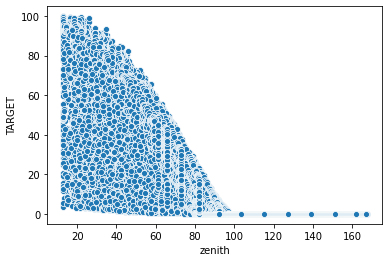

In [66]:
sns.scatterplot(x='zenith',y='TARGET',data=df)

In [67]:
train = df.copy()
print(train.shape)

(52560, 19)


### 10. azi (Azimuth: 방위각)

In [68]:
def azimuth(data):
    hra = math.radians(HRA(data))
    de = math.radians(delta(data))
    lat = math.radians(36)
    ele = math.radians(elevation(data))
    
    top = round(math.sin(de)*math.cos(lat) - math.cos(de)*math.sin(lat)*math.cos(hra),5)
    bottom = round(math.cos(ele),5)
    azi = math.degrees(math.acos(top/bottom))
    if hra > 0:
        return 360 - azi
    else:
        return azi
        
df = train.copy()
df['azi'] = [azimuth(train.iloc[i]) for i in range(len(df.index))]
df.head(1)

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,GHI,dew,sunny,sunrise,sunset,date,cloudy,temp_diff,delta,zenith,azi
0,0,0,0,0,0,1.5,69.08,-12,0.0,0,-16.522271,8.5,8.0,16.5,0,0.0,9,-23.169132,167.169132,0.0


In [69]:
train = df.copy()
print(train.shape)

(52560, 20)


In [72]:
train['date'].value_counts()

351    144
169    144
233    144
265    144
297    144
      ... 
53     144
85     144
117    144
365     96
0       48
Name: date, Length: 366, dtype: int64

### 새로운 train dataset 저장: train_new.csv

In [36]:
train.to_csv('train/train_new.csv',index=False)